# Estimación de peso y dimensiones de los envíos de Mercado Libre

Este notebook es una versión mínima y necesaria para poder levantar el dataset [meli_dataset_20190426.csv](https://drive.google.com/open?id=1tNUKD1lf1z8C7LPpCruiDl6SKBAHb79v) y comprender los features que éste contiene.

# Sobre el dataset
El dataset corresponde a un muestreo de envíos durante tres meses de 2018 en MLB (Mercado Libre Brasil), filtrados según métodos de envíos y por carriers (empresas de correos a cargo del envío propiamente dicho). A su vez, fue muestreado de forma no uniforme para romper de forma manual la distribución de los datos.

In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy
import seaborn
import scipy as sc

In [2]:
random.seed(0)

In [3]:
DATASET = 'meli_dataset_20190426.csv'

In [4]:
df = pd.read_csv(DATASET, low_memory=False)

In [5]:
df.columns

Index(['ITEM_ID', 'SHP_WEIGHT', 'SHP_LENGTH', 'SHP_WIDTH', 'SHP_HEIGHT',
       'ATTRIBUTES', 'CATALOG_PRODUCT_ID', 'CONDITION', 'DOMAIN_ID', 'PRICE',
       'SELLER_ID', 'STATUS', 'TITLE'],
      dtype='object')

#### ¿Qué significa cada columna?

* ITEM_ID: id unívoco de cada item publicado. (Ofuscado)
* SHP_WEIGHT: peso del paquete informado por el correo.
* SHP_LENGTH: largo del paquete informado por el correo.
* SHP_WIDTH: ancho del paquete informado por el correo.
* SHP_HEIGHT: altura del paquete informado por el correo.
* ATTRIBUTES: atributos como marca y modelo, entre otros, en formato json-lines
* CATALOG_PRODUCT_ID: id del catálogo (ofuscado).
* CONDITION: condición de venta (nuevo o usado).
* DOMAIN_ID: id de la categoría a la que pertenece la publicación.
* PRICE: precio en reales.
* SELLER_ID: id del vendedor (ofuscado).
* STATUS: estado de la publicación (activa, cerrada, pausada, etc.)
* TITLE: título de la publicación.

In [6]:
df.sample(5)

,ITEM_ID,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,ATTRIBUTES,CATALOG_PRODUCT_ID,CONDITION,DOMAIN_ID,PRICE,SELLER_ID,STATUS,TITLE
290758,FJEB1NDSY1,1020.0,36.6,18.8,5.7,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-DRILL_BITS,40.00,XYDSNCU3UV,active,Jogo / Kit De Serra Copo P/ Madeira C/ 12 Peça...
172094,VOAL870OUF,NaN,NaN,NaN,NaN,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-MASSAGE_CREAMS,39.99,EYCB7LVQH9,active,Pomada Massageadora Fisiofort Bio Instinto Com...
473143,PR5ET72H3U,126.0,25.0,11.0,5.0,NaN,H53U1H7Q5G,NaN,NaN,NaN,I0F7OAIAT5,under_review,Cabo Hdmi De 2m 8pin 1080p Para Ipad Iphone 5/...
243255,XVA92L238B,970.0,30.0,20.0,15.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-BOOTS_AND_BOOTIES,139.00,MJ6DKGFP9C,active,Bota Feminina Bico Quadrado Comfort Couro De C...
485004,KB0IBL212L,1641.0,30.0,20.0,15.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-BOOTS_AND_BOOTIES,99.90,JKEK75XL26,active,Bota Adventure + Palmilha Gel Cat Original! M...


In [7]:
df = df.dropna(subset=['SHP_WEIGHT'])
df = df.dropna(subset=['SHP_LENGTH'])
df = df.dropna(subset=['SHP_WIDTH'])
df = df.dropna(subset=['SHP_HEIGHT'])
df = df.dropna(subset=['PRICE'])
df.sample(3)


,ITEM_ID,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,ATTRIBUTES,CATALOG_PRODUCT_ID,CONDITION,DOMAIN_ID,PRICE,SELLER_ID,STATUS,TITLE
223835,BQEC9EQ5FA,972.0,25.0,25.0,10.0,"[{'id': 'APPLICATION_ZONES', 'name': 'Zonas de...",H53U1H7Q5G,new,MLB-FACE_MASKS,38.90,F3QWINA6WI,active,Filme Negro ( Rolopac Orgânico) - 10x100
108165,B8S4YPU20M,9500.0,70.6,68.4,47.9,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-POOL_COVERS,450.80,TC08G42LAD,active,Capa Termica Azul 300 Micras Piscina Aquecida ...
129520,YYKN19D6DA,1324.0,40.0,25.0,25.0,"[{'id': 'BODY_MATERIAL', 'name': 'Material do ...",H53U1H7Q5G,new,MLB-DRINK_DISPENSERS,42.99,OZ1BG8A2UN,active,Suqueira Vidro 3 Litros Torneira Refresqueira ...


El objetivo del análisis es predecir el peso y tamaño de los artículos. A su vez el tamaño se puede descomponer en largo, altura y ancho.  Las cuatro variables a predecir son numéricas continuas .
Probablemente la variable explicativa más importante sea DOMAIN_ID y ATTRIBUTES, dado que si se conoce el peso y tamaño de un artículo, los próximos envíos deberían tener las mismas características. En el caso de atributes, hay que preprocesar los datos para poder extraer algo de información.

Luego se dispone de otras variables complementarias, cuya incorporación podría incrementar el poder predictivo del modelo: CONDITION, STATUS, PRICE, SELLER_ID.

En primer lugar es conveniente relizar un análisis descriptivo, principalmente de las variables que se desea predecir.

## Analisis estadístico descriptivo de las variables peso, largo, altura y ancho

In [8]:
df[['SHP_WEIGHT', 'SHP_LENGTH', 'SHP_WIDTH', "SHP_HEIGHT", "PRICE"]].describe()

,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,PRICE
count,261958.000000,261958.000000,261958.000000,261958.000000,2.619580e+05
mean,1922.105799,31.907828,21.603207,11.771460,1.610124e+03
std,3305.257451,19.030625,11.479848,8.458347,5.952876e+05
min,1.000000,0.000000,0.000000,0.000000,1.000000e-01
25%,260.000000,20.000000,13.000000,5.000000,4.890000e+01
50%,710.000000,25.000000,20.000000,10.000000,1.000000e+02
75%,2045.000000,37.000000,25.300000,16.000000,1.790000e+02
max,50000.000000,288.200000,165.000000,105.000000,3.032487e+08


In [9]:
#plt.figure(figsize=(17,5))
#seaborn.jointplot(data=df,
 #                 x='SHP_WEIGHT', y='STATUS', kind='hex')
#seaborn.despine()

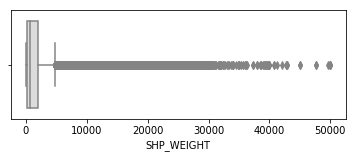

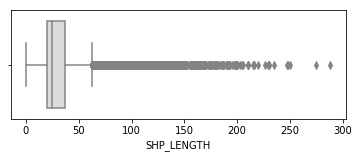

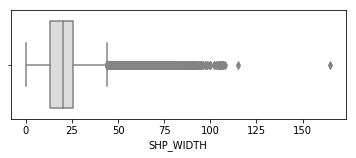

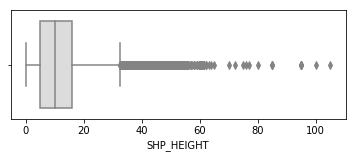

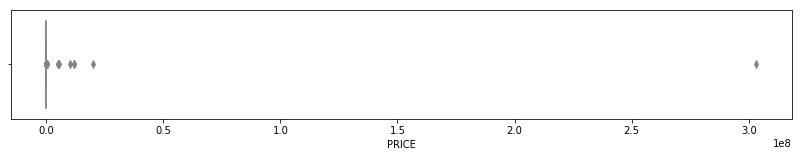

In [10]:
plt.figure(figsize=(6,2))
seaborn.boxplot(x="SHP_WEIGHT", data=df, palette="coolwarm")
plt.figure(figsize=(6,2))
seaborn.boxplot(x="SHP_LENGTH", data=df, palette="coolwarm")
plt.figure(figsize=(6,2))
seaborn.boxplot(x="SHP_WIDTH", data=df, palette="coolwarm")
plt.figure(figsize=(6,2))
seaborn.boxplot(x="SHP_HEIGHT", data=df, palette="coolwarm")
plt.figure(figsize=(14,2))
seaborn.boxplot(x="PRICE", data=df, palette="coolwarm")

In [11]:
ku = sc.stats.kurtosis(df["SHP_WEIGHT"])
print('Kurtosis de SHP_WEIGHT: {}'.format(ku))
sw = sc.stats.skew(df["SHP_WEIGHT"])
print('Swewness de SHP_WEIGHT: {}'.format(sw))

Kurtosis de SHP_WEIGHT: 20.3337741704888
Swewness de SHP_WEIGHT: 3.8771461646001493


In [12]:
ku = sc.stats.kurtosis(df["SHP_LENGTH"])
print('Kurtosis de SHP_LENGTH: {}'.format(ku))
sw = sc.stats.skew(df["SHP_LENGTH"])
print('Swewness de SHP_LENGTH: {}'.format(sw))

Kurtosis de SHP_LENGTH: 7.8631970565292395
Swewness de SHP_LENGTH: 2.218799890787704


In [13]:
ku = sc.stats.kurtosis(df["SHP_WIDTH"])
print('Kurtosis de SHP_WIDTH: {}'.format(ku))
sw = sc.stats.skew(df["SHP_WIDTH"])
print('Swewness de SHP_WIDTH: {}'.format(sw))

Kurtosis de SHP_WIDTH: 3.9594406619238782
Swewness de SHP_WIDTH: 1.4387479349749213


In [14]:
ku = sc.stats.kurtosis(df["SHP_HEIGHT"])
print('Kurtosis de SHP_HEIGHT: {}'.format(ku))
sw = sc.stats.skew(df["SHP_HEIGHT"])
print('Swewness de SHP_HEIGHT: {}'.format(sw))

Kurtosis de SHP_HEIGHT: 2.807968975403252
Swewness de SHP_HEIGHT: 1.3916424998419754


In [15]:
ku = sc.stats.kurtosis(df["PRICE"])
print('Kurtosis de PRICE: {}'.format(ku))
sw = sc.stats.skew(df["PRICE"])
print('Swewness de PRICE: {}'.format(sw))

Kurtosis de PRICE: 257073.23794598793
Swewness de PRICE: 504.87146548769505


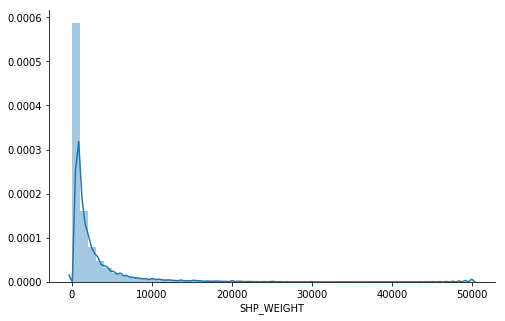

In [16]:
plt.figure(figsize=(8, 5))
seaborn.distplot(df['SHP_WEIGHT'], label='SHP_WEIGHT')
seaborn.despine()

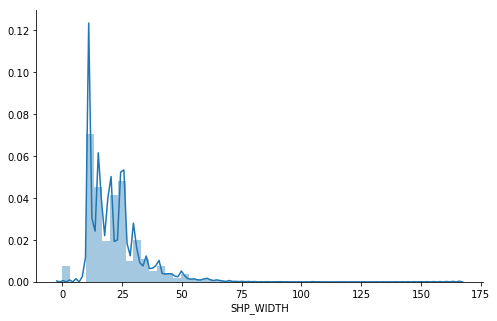

In [17]:
plt.figure(figsize=(8,5))
seaborn.distplot(df['SHP_WIDTH'], label='SHP_WIDTH')
seaborn.despine()

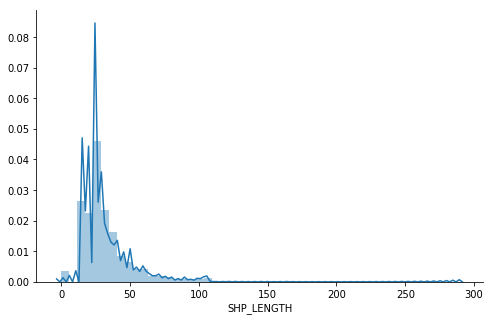

In [18]:
plt.figure(figsize=(8,5))
seaborn.distplot(df['SHP_LENGTH'], label='SHP_LENGTH')
seaborn.despine()

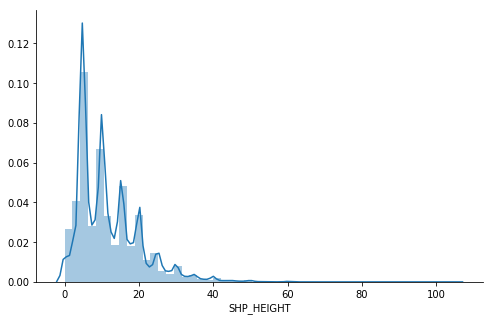

In [19]:
plt.figure(figsize=(8,5))
seaborn.distplot(df['SHP_HEIGHT'], label='SHP_HEIGHT')
seaborn.despine()

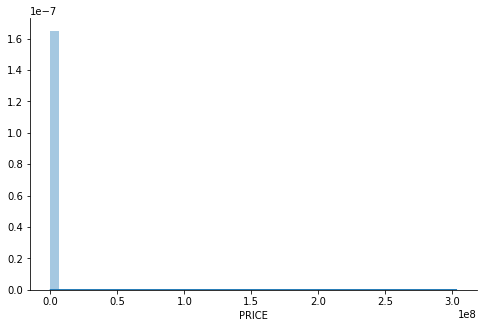

In [20]:
plt.figure(figsize=(8,5))
seaborn.distplot(df['PRICE'], label='PRICE')
seaborn.despine()

In [21]:
pd.value_counts(df['CONDITION'])

new              260579
used               1023
not_specified       356
Name: CONDITION, dtype: int64

In [22]:
pd.value_counts(df['STATUS'])

active    161502
paused     82196
closed     18260
Name: STATUS, dtype: int64

In [23]:
pd.value_counts(df['DOMAIN_ID'])

MLB-VEHICLE_ACCESSORIES                            6856
MLB-SUPPLEMENTS                                    5780
MLB-VEHICLE_PARTS                                  4454
MLB-HAIR_TREATMENTS                                3273
MLB-BACKPACKS                                      3119
MLB-HOME_APPLIANCES_ACCESSORIES_AND_SPARE_PARTS    2890
MLB-CELLPHONE_LCD_SCREENS                          2865
MLB-CELLPHONES                                     2738
MLB-ARTS_AND_CRAFTS                                2606
MLB-ELECTRONIC_PRODUCTS                            2538
MLB-CELLPHONE_COVERS                               2354
MLB-KITCHEN_SUPPLIES                               2339
MLB-BOOTS_AND_BOOTIES                              2249
MLB-T_SHIRTS                                       2186
MLB-SOUVENIRS                                      2124
MLB-COMPUTER_EQUIPMENT_AND_SPARE_PARTS             2008
MLB-TOOLS                                          1958
MLB-PERFUMES                                    

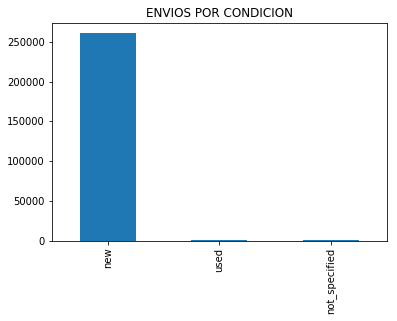

In [24]:
plot = df['CONDITION'].value_counts().plot(kind='bar',
                                            title='ENVIOS POR CONDICION')

En los envíos por condición la categoria modal es nuevo como refleja el gráfico, superando ampliamente las demás categorías

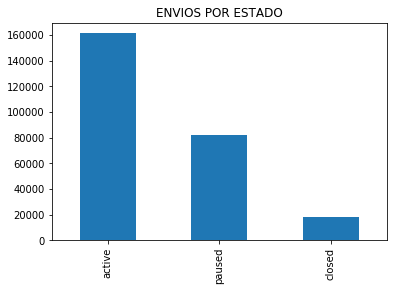

In [25]:
plot = df['STATUS'].value_counts().plot(kind='bar',
                                            title='ENVIOS POR ESTADO')

En los envíos por estado la categoria mas frecuente es activo

## ¿Qué criterios les parece mejor para limpiar el dataset de datos faltantes?

Los datos o el conjunto de datos del que disponemos a menudo no están completos para ser analizados apropiadamente.
La limpieza de los datos consiste en reemplazarlos o eliminarlos de una forma tal que, el resultado final se vea afectado lo menos posible.
Criterios que se podrían considerar para la limpieza:
- Eliminar registros con datos faltantes, eliminado filas con 1 dato faltante, campos nulos que superen una cantidad, o ciertos campos nulos no permitidos
- Reemplazar los valores faltantes con un dato que podría ser, la media, la mediana o la moda de acuerdo al tipo de distribución que tienen los datos
- Comparar los resultados para analizar el impacto considerando ambas alternativas

Para nuestro caso el criterio elegido es eliminar los registros en los que falte alguna de las medidas de peso, precio y volumen.
Vamos a partir de datos completos y los registros que queden fuera del análisis pueden usarse a futuro para determinar Qué valor sería
acorde para completarlos.

## Conclusiones sobre las distribuciones de las variables a predecir


Se aprecia que las cuatro variables a predecir tienen distribuciones con asimetría izquierda bastante marcada, especialmente el peso de los productos. Adempas las cuatro distribuciones son leptocúrticas o sea mas puntiagudas de que la distribución normal. También puede decirse que las variables no tienen distribuciones tan heterogéneas como se podría esperar, pero sí presentan múltiples outliers.

## Categorias/Dominios con mayor homegeneidad y heterogeneidad

In [51]:
df = df.dropna(subset=['SHP_WEIGHT', 'SHP_LENGTH', 'SHP_WIDTH', 'SHP_HEIGHT', 'PRICE'])

df = df.head(10000) #esto no iria, solo tomo 10000 para q no demore tanto

for i, row in df.iterrows():

    #setear en cada registro del data set el coeficiente de variacion de ese peso o medidas en nuevas columnas 
    #CF_SHP_WEIGHT, CF_x, CF_X, CF_X
    
    df.loc[i,'CF_SHP_WEIGHT'] = sc.stats.variation(df.loc[i,'SHP_WEIGHT'])
    df.loc[i,'CF_SHP_LENGTH'] = sc.stats.variation(df.loc[i,'SHP_LENGTH'])
    df.loc[i,'CF_SHP_WIDTH'] = sc.stats.variation(df.loc[i,'SHP_WIDTH'])
    df.loc[i,'CF_SHP_HEIGHT'] = sc.stats.variation(df.loc[i,'SHP_HEIGHT'])
    
#Agrupando ordenando descendente los mejores coeficientes por cada variable de medicion
#Los que tengan valores mas alto son los mas heterogeneos
df_het_cf_shp_weight = df[['DOMAIN_ID', 'CF_SHP_WEIGHT']].sort_values('CF_SHP_WEIGHT', ascending=False)
df_het_cf_shp_length = df[['DOMAIN_ID', 'CF_SHP_LENGTH']].sort_values('CF_SHP_LENGTH', ascending=False)
df_het_cf_shp_width = df[['DOMAIN_ID', 'CF_SHP_WIDTH']].sort_values('CF_SHP_WIDTH', ascending=False)
df_het_cf_shp_height = df[['DOMAIN_ID', 'CF_SHP_HEIGHT']].sort_values('CF_SHP_HEIGHT', ascending=False)

#se armaron listas ordenadas con cada variable y se va a extraer las categorias unicas
print('TOP 20 CATEGORIAS CON SHP_WEIGHT HETEROGENEO')
print(df_het_cf_shp_weight['DOMAIN_ID'][:20].unique())

print('TOP 20 CATEGORIAS CON SHP_LENGTH HETEROGENEO')
print(df_het_cf_shp_length['DOMAIN_ID'][:20].unique())

print('TOP 20 CATEGORIAS CON SHP_WIDTH HETEROGENEO')
print(df_het_cf_shp_width['DOMAIN_ID'][:20].unique())

print('TOP 20 CATEGORIAS CON SHP_HEIGHT HETEROGENEO')
print(df_het_cf_shp_height['DOMAIN_ID'][:20].unique())


#Los que tengan valores mas alto son los mas heterogeneos

TOP 20 CATEGORIAS CON SHP_WEIGHT HETEROGENEO
['MLB-SKIN_CARE_SUPPLIES' 'MLB-STREAMING_MEDIA_DEVICES'
 'MLB-VEHICLE_ACCESSORIES' 'MLB-PANTS' 'MLB-PC_KEYBOARDS'
 'MLB-FACIAL_SKIN_CARE_PRODUCTS' 'MLB-HOME_APPLIANCES'
 'MLB-BICYCLE_GROUPSETS' 'MLB-COMBINED_TOOL_SETS'
 'MLB-PC_THERMAL_COMPOUND_PASTES' 'MLB-KITCHEN_POTS'
 'MLB-BOOTS_AND_BOOTIES' 'MLB-NEBULIZERS' 'MLB-NAIL_STRENGTHENERS'
 'MLB-SHORTS' 'MLB-JACKETS_AND_COATS']
TOP 20 CATEGORIAS CON SHP_LENGTH HETEROGENEO
['MLB-SKIN_CARE_SUPPLIES' 'MLB-WATCH_BOXES' 'MLB-VEHICLE_ACCESSORIES'
 'MLB-PANTS' 'MLB-PC_KEYBOARDS' 'MLB-FACIAL_SKIN_CARE_PRODUCTS'
 'MLB-HOME_APPLIANCES' 'MLB-BICYCLE_GROUPSETS' 'MLB-COMBINED_TOOL_SETS'
 'MLB-PC_THERMAL_COMPOUND_PASTES' 'MLB-KITCHEN_POTS'
 'MLB-STREAMING_MEDIA_DEVICES' 'MLB-BOOTS_AND_BOOTIES'
 'MLB-NAIL_STRENGTHENERS' 'MLB-SHORTS' 'MLB-BLOUSES']
TOP 20 CATEGORIAS CON SHP_WIDTH HETEROGENEO
['MLB-SKIN_CARE_SUPPLIES' 'MLB-WATCH_BOXES' 'MLB-VEHICLE_ACCESSORIES'
 'MLB-PANTS' 'MLB-PC_KEYBOARDS' 'MLB-FACIAL_SKIN_C

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1025: RuntimeWarning: invalid value encountered in double_scalars
  return a.std(axis) / a.mean(axis)


In [ ]:
## COMO TRATAR LOS OUTLIERS, SERGIO ANOTAR